# Parameterized Circuits and Parameter Expressions in Qiskit

This notebook shows how to use parameters in Qiskit circuits, how to build
symbolic expressions with several parameters, how to bind values, and how to
visualize results.

Content:
1. Basic parameter usage  
2. Single parameter applied to several qubits  
3. Composite parameter expressions  
4. Deep dive: ParameterExpression (substitution, math functions, evaluation)  
5. Binding multiple parameters  
6. Practical example with a loop  


In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_bloch_multivector

from qiskit.quantum_info  import Statevector

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit.visualization import circuit_drawer

import numpy as np

## 1. A single parameter and different names

A parameter is a symbolic angle.

The name only changes the label in the circuit diagram. It does not change the math.


Circuit with parameter named 'phi':


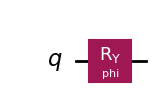

In [2]:
# One parameter with name "theta"
phi = Parameter("phi")
qc_phi = QuantumCircuit(1)
qc_phi.ry(phi, 0)


print("Circuit with parameter named 'phi':")
qc_phi.draw(output="mpl")

Circuit with parameter named ' test ':


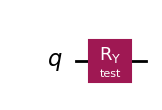

In [3]:
# One parameter with name "theta"
phi = Parameter("test")
qc_phi = QuantumCircuit(1)
qc_phi.ry(phi, 0)


print("Circuit with parameter named '", phi.name, "':")
qc_phi.draw(output="mpl")

## 2. One parameter used on several qubits

Here we use one parameter `phi` on four qubits:

- Qubit 0: angle = `phi`
- Qubit 1: angle = `2 * phi`
- Qubit 2: angle = `3 * phi`
- Qubit 3: angle = `4 * phi`

The same symbol controls all rotations, with different factors.

Then we assign `phi = π/4` and look at the qubits on the Bloch sphere.

Parameterized circuit with phi, 2*phi, 3*phi, 4*phi:


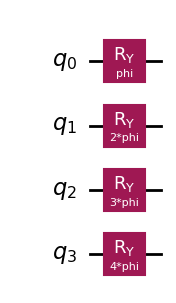

In [4]:
# Define the parameter
phi = Parameter("phi")

# Create a 4-qubit circuit
qc_multi = QuantumCircuit(4)

# Apply phi, 2*phi, 3*phi, 4*phi
qc_multi.ry(phi, 0)
qc_multi.ry(2 * phi, 1)
qc_multi.ry(3 * phi, 2)
qc_multi.ry(4 * phi, 3)

print("Parameterized circuit with phi, 2*phi, 3*phi, 4*phi:")
qc_multi.draw(output="mpl")


Circuit with phi = π/4:
Bloch spheres for the four qubits:


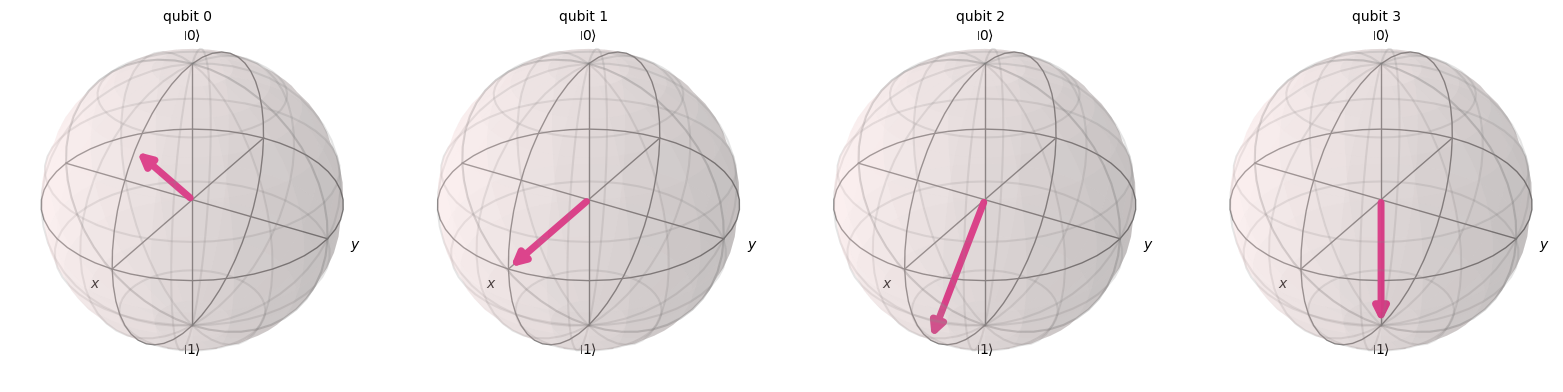

In [5]:
# Assign phi = π/4
phi_value = np.pi / 4
qc_bound_multi = qc_multi.assign_parameters({phi: phi_value})


print(f"Circuit with phi = π/4:")
qc_bound_multi.draw(output="mpl")

# Get the statevector for the bound circuit
state = Statevector.from_instruction(qc_bound_multi)

# Plot Bloch spheres for each qubit
print("Bloch spheres for the four qubits:")
plot_bloch_multivector(state)


## 5. Composite parameter expressions

Parameters can be combined into simple symbolic expressions such as:

- `a + 2*b`
- `2 * theta`
- `b - a`

These are already `ParameterExpression` objects.

The circuit keeps such expressions symbolically until numerical values
are assigned.  
This makes it easy to express relationships between parameters.

Circuit with composite parameter expression a + 2*b:


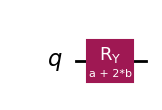

Circuit after binding a=0.2, b=0.5:


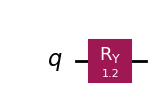

Numeric angle a + 2*b = 1.2


In [6]:
# Two base parameters
a = Parameter("a")
b = Parameter("b")

# Composite expression
theta_expr = a + 2 * b

# Use the expression in a circuit
qc_expr = QuantumCircuit(1)
qc_expr.ry(theta_expr, 0)

print("Circuit with composite parameter expression a + 2*b:")
display(qc_expr.draw("mpl", cregbundle=False))

# Assign concrete values
vals = {a: 0.2, b: 0.5}
qc_expr_bound = qc_expr.assign_parameters(vals)

print("Circuit after binding a=0.2, b=0.5:")
display(qc_expr_bound.draw("mpl", cregbundle=False))

# Show the numeric angle
theta_numeric = float(theta_expr.bind(vals))
print("Numeric angle a + 2*b =", theta_numeric)

## 6. ParameterExpressions: What they are and how they work

A `ParameterExpression` is a symbolic formula built from one or more
parameters.  
It is more powerful than a single `Parameter`, because it can represent:

- sums (`a + b`)
- scaled parameters (`2 * theta`)
- nested expressions (`a + 2*(b + 1)`)
- math functions (`sin(a)`, `exp(a + b)`)

### Why do we need ParameterExpressions?

Many quantum circuits use angles that depend on symbolic relationships.
Common examples:

- variational algorithms (VQE, QAOA),
- shared parameters across multiple qubits,
- formulas like `2*a + 3*b`,
- building reusable symbolic components.

Qiskit keeps these expressions symbolic until we bind numerical values.

### Parameter vs ParameterExpression

| Feature | Parameter | ParameterExpression |
|--------|-----------|----------------------|
| Represents a single symbol | ✔ | – |
| Can combine multiple parameters | – | ✔ |
| Supports math (`sin`, `cos`, `exp`, …) | – | ✔ |
| Can be bound numerically with `.bind()` | – | ✔ |
| Can be used inside a circuit | ✔ | ✔ |

**Rule of thumb:**  
A `ParameterExpression` is created automatically whenever you *combine parameters* in any way.


## 7. Examples: building and using ParameterExpressions

Below we create a symbolic expression, perform substitution, evaluate it,
and then use it inside a circuit and bind numeric values.


In [7]:
# Define base parameters
a = Parameter("a")
b = Parameter("b")

# Build a symbolic expression
expr = 2*a + 3*b
print("Symbolic expression:", expr)

# Substitute part of the expression
expr_sub = expr.subs({b: a + 1})
print("After substitution:", expr_sub)

# Bind numbers and evaluate
value = float(expr.bind({a: 1, b: 2}))
print("Numeric result =", value)

Symbolic expression: 2*a + 3*b
After substitution: 2*a + 3*(1 + a)
Numeric result = 8.0


Circuit with symbolic expression:


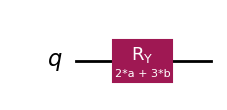

Expression after substitution: 2*a + 3*(1 + a)
Circuit after binding a=0.5, b=1.0:


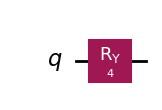

Numeric value = 4.0


In [8]:
# Parameters
a = Parameter("a")
b = Parameter("b")

# Build symbolic expression
expr = 2*a + 3*b

# Create a circuit using the expression
qc = QuantumCircuit(1)
qc.ry(expr, 0)

print("Circuit with symbolic expression:")
display(qc.draw("mpl", cregbundle=False))

# Substitute b → (a + 1)
expr2 = expr.subs({b: a + 1})
print("Expression after substitution:", expr2)

# Bind numerical values
qc_bound = qc.assign_parameters({a: 0.5, b: 1.0})

print("Circuit after binding a=0.5, b=1.0:")
display(qc_bound.draw("mpl", cregbundle=False))

# Evaluate the expression numerically
value = float(expr.bind({a: 0.5, b: 1.0}))
print("Numeric value =", value)

## 4. Assigning several parameters and substituting

We can:

- Assigning several parameters at once,
- substitute one parameter by an expression using other parameters.

This lets us reuse and reshape circuits without rewriting them.

Original circuit with parameters x, y, z:


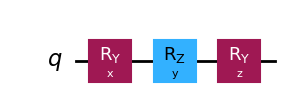

In [26]:
# Three parameters
x = Parameter("x")
y = Parameter("y")
z = Parameter("z")

# Circuit with three parameterized rotations
qc_multi_param = QuantumCircuit(1)
qc_multi_param.ry(x, 0)
qc_multi_param.rz(y, 0)
qc_multi_param.ry(z, 0)

print("Original circuit with parameters x, y, z:")
qc_multi_param.draw(output="mpl")

Circuit after binding x=0.1, y=0.2 (z still symbolic):


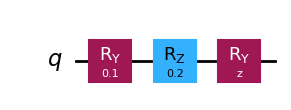

In [ ]:
# Assign two parameters, leave z symbolic
qc_bound_two = qc_multi_param.assign_parameters({x: 0.1, y: 0.2})

print("Circuit after assigning x=0.1, y=0.2 (z still symbolic):")
qc_bound_two.draw(output="mpl")

Circuit after substituting z → x + y:


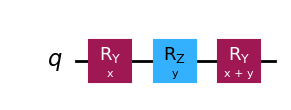

In [29]:
# Substitute z by an expression using x and y
z_expr = x + y
qc_sub = qc_multi_param.assign_parameters({z: z_expr})

print("Circuit after substituting z → x + y:")
qc_sub.draw(output="mpl")

## 5. Math functions on parameters

Parameter expressions support simple math functions.

Some examples:

| Function | Idea                       | Tiny example              |
|---------|----------------------------|---------------------------|
| `sin()` | Sine of the expression     | `(2 * θ).sin()`          |
| `cos()` | Cosine of the expression   | `(θ + φ).cos()`          |
| `exp()` | Exponential                | `θ.exp()`                |
| `abs()` | Absolute value             | `(-θ).abs()`             |
| `log()` | Natural log (ln)           | `(θ + 1).log()`          |

In [31]:
from math import pi

# Single parameter
theta_m = Parameter("theta_m")

# Create simple expressions
expr_sin = theta_m.sin()           # sin(theta)
expr_cos = theta_m.cos()           # cos(theta)
expr_exp = theta_m.exp()           # exp(theta)
expr_abs = (-theta_m).abs()        # | -theta |
expr_log = (theta_m + 1).log()     # log(theta + 1)

# Use a very simple numeric value
value = 1.0
vals = {theta_m: value}

print(f"Using theta = {value}")
print("sin(theta)      =", float(expr_sin.bind(vals)))
print("cos(theta)      =", float(expr_cos.bind(vals)))
print("exp(theta)      =", float(expr_exp.bind(vals)))
print("|-theta|        =", float(expr_abs.bind(vals)))
print("log(theta + 1)  =", float(expr_log.bind(vals)))


Using theta = 1.0
sin(theta)      = 0.8414709848078965
cos(theta)      = 0.5403023058681398
exp(theta)      = 2.718281828459045
|-theta|        = 1.0
log(theta + 1)  = 0.6931471805599453


## 6. Practical example: parameter scan with a loop

Here we:

- build a simple 1-qubit circuit with a parameter `theta`,
- sweep `theta` from 0 to 2π,
- run a simulator for each value in a Python loop,
- record the probability of measuring `1`.

This shows how a single parameter controls the measurement outcome.

Base circuit for the parameter scan:


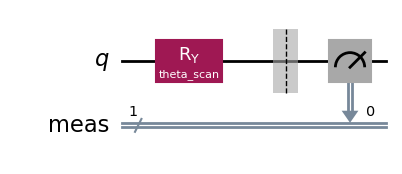

In [32]:
# Define the parameter and the circuit
theta_scan = Parameter("theta_scan")
qc_scan = QuantumCircuit(1)
qc_scan.ry(theta_scan, 0)
qc_scan.measure_all()

print("Base circuit for the parameter scan:")
display(qc_scan.draw(output="mpl"))


theta = 0: counts = {'0': 100}, P(1) = 0.000
theta = π/4: counts = {'0': 85, '1': 15}, P(1) = 0.150
theta = π/2: counts = {'0': 55, '1': 45}, P(1) = 0.450
theta = 3π/4: counts = {'1': 86, '0': 14}, P(1) = 0.860
theta = π: counts = {'1': 100}, P(1) = 1.000

Combined histogram for all theta values:


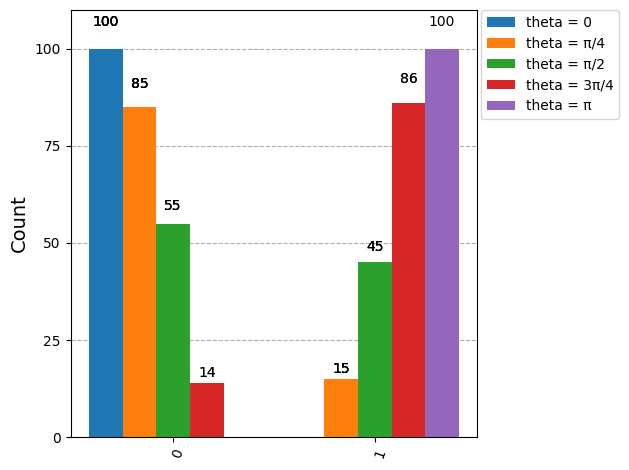

In [36]:
# Statevector-basierten Simulator mit Sampling nutzen
simulator = AerSimulator(method='statevector')

# Diskrete theta-Werte
theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
theta_labels = [0, r"π/4", r"π/2", r"3π/4", r"π"]

all_counts = []
prob_1 = []

for theta, label in zip(theta_values, theta_labels):
    # Parameter im Circuit setzen
    qc_bound = qc_scan.assign_parameters({theta_scan: theta})
    
    # Simulation mit 100 Schüssen
    result = simulator.run(qc_bound, shots=100).result()
    counts = result.get_counts(qc_bound)
    
    all_counts.append(counts)
    
    # Wahrscheinlichkeit für Ergebnis "1"
    p1 = counts.get("1", 0) / 100
    prob_1.append(p1)
    
    print(f"theta = {label}: counts = {counts}, P(1) = {p1:.3f}")

print("\nCombined histogram for all theta values:")
plot_histogram(all_counts, legend=[f"theta = {lbl}" for lbl in theta_labels])



# simulator = AerSimulator(method='statevector')
# result = simulator.run(bell, shots=10000).result()

# counts = result.get_counts(bell)

# print("Messresultate:", counts)
# plot_histogram(counts)'


### Summary

- Parameters let us define circuits symbolically.
- The same parameter can be reused with different factors on many qubits.
- We can combine, bind, and substitute parameters to reshape circuits.
- Math functions work directly on parameter expressions.
- A simple loop over bound values is enough to explore how outcomes change.

This pattern is the core of many variational quantum algorithms.

*Materials:*
- https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.Parameter
- https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.QuantumCircuit
- https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.ParameterExpression

## Assign vs Bind (Short Summary)

- **assign_parameters**  
  Applies to a *QuantumCircuit*.  
  It replaces symbolic parameters inside the circuit.  
  Result: a new circuit.

- **bind**  
  Applies to a *ParameterExpression*.  
  It replaces symbols inside a mathematical expression.  
  Result: a new expression or a numeric value.

**Rule of thumb:**  
- Circuits → use **assign**  
- Expressions → use **bind**


Original expression: theta + 2*phi
Expression after bind: 7
Numeric value: 7.0

Original circuit:


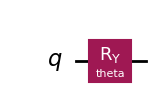

Circuit after assign_parameters:


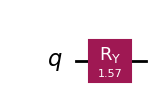

In [9]:

# --- Define parameters ---
theta = Parameter("theta")
phi = Parameter("phi")

# --- ParameterExpression ---
expr = theta + 2 * phi
print("Original expression:", expr)

# Bind expression (works only on expressions, not circuits)
expr_bound = expr.bind({theta: 1, phi: 3})
print("Expression after bind:", expr_bound)
print("Numeric value:", float(expr_bound))

# --- Circuit using a parameter ---
qc = QuantumCircuit(1)
qc.ry(theta, 0)

print("\nOriginal circuit:")
display(qc.draw(output="mpl"))

# Assign parameter to the circuit
qc_assigned = qc.assign_parameters({theta: 1.57})

print("Circuit after assign_parameters:")
display(qc_assigned.draw(output="mpl"))
